### Importing libraries

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Data Loading

#### Working with ucf101 dataset



In [2]:
# Download dataset 

!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'ucf101_top5.tar.gz'


In [ ]:
train_path = './train'
test_path = './test'

In [ ]:
train_files = os.listdir(train_path)
print('Number of vidoes in train dir: {}'.format(len(train_files)))
print(train_files[:10])   # first 10 videos in train dir

Number of vidoes in train dir: 594
['v_TennisSwing_g18_c01.avi', 'v_PlayingCello_g08_c03.avi', 'v_ShavingBeard_g22_c01.avi', 'v_CricketShot_g16_c02.avi', 'v_PlayingCello_g25_c05.avi', 'v_TennisSwing_g20_c04.avi', 'v_CricketShot_g09_c06.avi', 'v_PlayingCello_g18_c02.avi', 'v_CricketShot_g19_c05.avi', 'v_PlayingCello_g20_c06.avi']


In [ ]:
test_files = os.listdir(test_path)
print('Number of vidoes in test dir: {}'.format(len(test_files)))
print(test_files[:10])  # first 10 videos in test dir

Number of vidoes in test dir: 224
['v_TennisSwing_g07_c03.avi', 'v_Punch_g02_c02.avi', 'v_Punch_g04_c03.avi', 'v_ShavingBeard_g03_c04.avi', 'v_PlayingCello_g06_c07.avi', 'v_TennisSwing_g01_c02.avi', 'v_CricketShot_g05_c02.avi', 'v_CricketShot_g07_c02.avi', 'v_Punch_g05_c01.avi', 'v_TennisSwing_g01_c07.avi']


### Utilities

In [ ]:
def trace(x, var):
  print("Shape of {}: {}".format(var , x.shape))

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Validation loss decreased. Saving checkpoint...")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

def plot_loss(train_loss, val_loss, save_fig=False):
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(train_loss, label='Train Loss')
  plt.plot(val_loss, label='Val Loss')
  plt.legend()
  plt.title('Train loss vs Validation Loss')
  plt.savefig('loss.png')
  plt.show()

In [ ]:
# Hyperparameters
MAX_FRAMES = 20
IMG_SIZE = 128
MAX_PREDS = 1
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 8
HIDDEN_DIM = 16
LR = 0.0001
EPOCHS = 100
OPTIM = 'adam'
LAMBDA = 0.001

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data Pre-processing

Extracting frames from video and making it suitable to feed to model

In [ ]:
def crop_center_square(frame):
  y,x = frame.shape[0:2]
  min_dim = min(y,x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim, start_x:start_x+min_dim, :]

def load_video(path, resize=(IMG_SIZE,IMG_SIZE), max_frames=0, resize_manually=1):
  cap = cv2.VideoCapture(path)
  fps = int(cap.get(cv2.cv2.CAP_PROP_FPS))
  # print(fps)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break

      if resize_manually:
        frame = crop_center_square(frame)
        frame = cv2.resize(frame, resize)
      # trace(frame, 'frame')
      # frame = frame[:, :, [2,1,0]]  # BGR to RGB
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # BGR to GRAY
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  
  frames = np.array(frames)
  frames = np.expand_dims(frames, axis=3)

  return frames

In [ ]:
path = os.path.join(train_path, 'v_CricketShot_g15_c01.avi')
frames = load_video(path, resize=(IMG_SIZE,IMG_SIZE), max_frames=MAX_FRAMES)
trace(frames, 'frames')

Shape of frames: (20, 128, 128, 1)


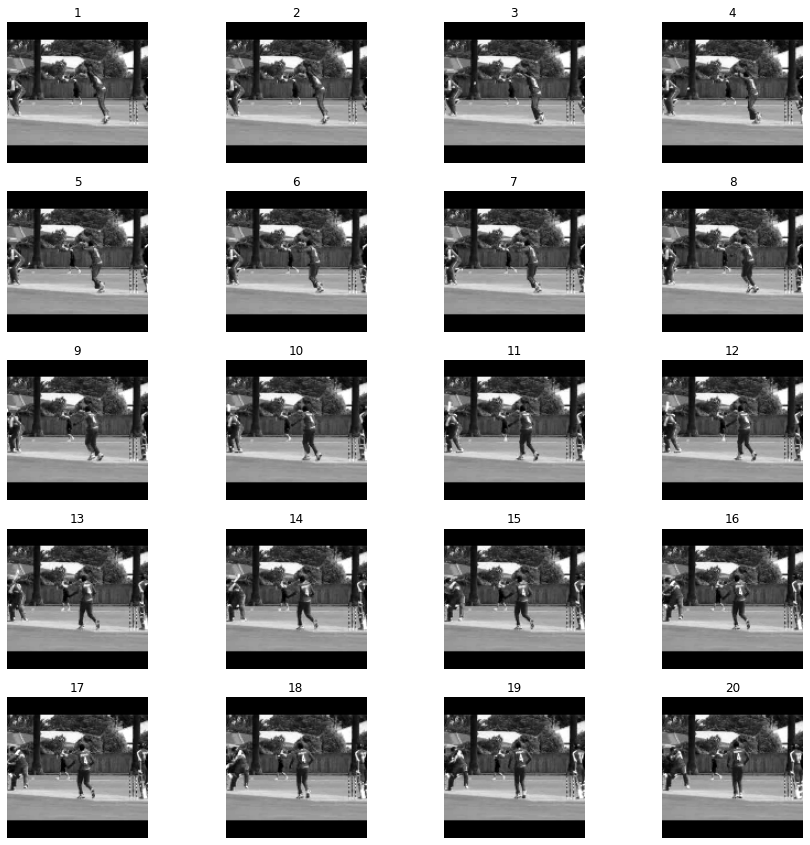

In [ ]:
num_cols = 4
num_rows = MAX_FRAMES // num_cols
f, ax = plt.subplots(num_rows, num_cols)
comp = 0

for i in range(num_rows):
  for j in range(num_cols):
    comp += 1
    frame = frames[i*num_cols+j]
    ax[i,j].imshow(frame[:, :, 0], cmap='gray')
    ax[i,j].set_title(comp)
    ax[i,j].axis('off')

  f.set_figheight(15)
  f.set_figwidth(15)

plt.show()

#### Make Custom Dataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dir, video_list, img_size=(IMG_SIZE,IMG_SIZE), max_frames=12, max_preds=1, transform=None):
    """
      Parameters
      -----------
        dir: path to train directory or test directory
        video_list: contains .avi files in dir
        img_size: resize frames to image size 
        max_frames: divide video into max number of frames
        max_preds: number of frames to be predicted
    """
    self.dir = dir
    self.video_list = video_list
    self.img_size = img_size
    self.max_frames = max_frames
    self.max_preds = max_preds
    self.transform = transform

  def __len__(self):
    return len(self.video_list)
  
  def __getitem__(self, index):
    path = os.path.join(self.dir, self.video_list[index])
    frames = load_video(path, max_frames=self.max_frames, resize_manually=True, resize=self.img_size)

    input_frames_size = self.max_frames-self.max_preds
    target_frames_size = self.max_preds

    input_frames = frames[:input_frames_size]
    target_frames = frames[self.max_frames-self.max_preds:]

    input_frames_tensor = torch.zeros((input_frames_size, 1, self.img_size[0], self.img_size[1]))
    target_frames_tensor = torch.zeros((target_frames_size, 1, self.img_size[0], self.img_size[1]))

    if self.transform is not None:
      for f in range(input_frames.shape[0]):
        input_frames_tensor[f] = self.transform(input_frames[i])
      for f in range(target_frames.shape[0]):
        target_frames_tensor[f] = self.transform(target_frames[f])
    
    target_frames_tensor = target_frames_tensor * 255.0

    return (input_frames_tensor, target_frames_tensor)

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(),
                                ])

train_size = int(len(train_files) * TRAIN_VAL_SPLIT)

random.shuffle(train_files)
train_videos = train_files[:train_size]
val_videos = train_files[train_size:]

train_dataset = CustomDataset(train_path, train_videos, transform=transform, max_preds=MAX_PREDS, max_frames=MAX_FRAMES)
val_dataset = CustomDataset(train_path, val_videos, transform=transform, max_preds=MAX_PREDS, max_frames=MAX_FRAMES)
test_dataset = CustomDataset(test_path, test_files, transform=transform, max_preds=MAX_PREDS, max_frames=MAX_FRAMES)

In [ ]:
x,y = train_dataset[0]
trace(x, 'x')
trace(y, 'y')
# Shape of both x and y: (frames, channels, h, w)

Shape of x: torch.Size([19, 1, 128, 128])
Shape of y: torch.Size([1, 1, 128, 128])


In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

print('Length of train loader: {}'.format(len(train_loader)))
print('Length of val loader: {}'.format(len(val_loader)))
print('Length of test loader: {}'.format(len(test_loader)))

Length of train loader: 60
Length of val loader: 15
Length of test loader: 28


In [ ]:
x,y = next(iter(train_loader))
trace(x, 'x')
trace(y, 'y')
# Shape of both x and y: (batch_size, frames, channels, h, w)

Shape of x: torch.Size([8, 19, 1, 128, 128])
Shape of y: torch.Size([8, 1, 1, 128, 128])


### Data Visualization from created loaders

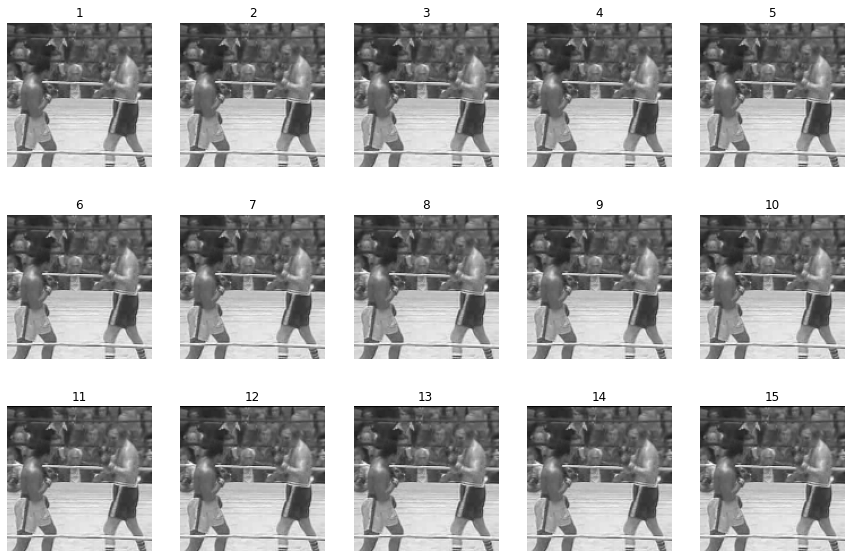

In [ ]:
idx = np.random.randint(0, x.shape[0])
v = x[idx]
num_frames = v.shape[0] - 1
num_cols = 5
num_rows = num_frames // num_cols
f, ax = plt.subplots(num_rows, num_cols)
comp = 0

for i in range(num_rows):
  for j in range(num_cols):
    comp += 1
    frame = v[i*num_cols+j]
    ax[i,j].imshow(frame[0], cmap='gray')
    ax[i,j].set_title(comp)
    ax[i,j].axis('off')

  f.set_figheight(10)
  f.set_figwidth(15)

plt.show()

## Building Model

### ConvLSTM Cell

$i_{t} = \sigma (W_{xi} * X_{t} + W_{hi} * H_{t-1} + W_{ci} \circ C_{t-1} + b_{i})$ \\
$f_{t} = \sigma (W_{xf} * X_{t} + W_{hf} * H_{t-1} + W_{cf} \circ C_{t-1} + b_{f})$ \\
$C_{t} = f_{t} \circ C_{t-1} + i_{t} \circ \tanh (W_{xc} * X_{t} + W_{hc} * H_{t-1} + b_{c})$ \\
$o_{t} = \sigma (W_{xo} * X_{t} + W_{ho} * H_{t-1} + W_{co} \circ C_{t} + b_{o})$ \\
$H_{t} = o_{t} \circ \tanh(C_{t})$



In [ ]:
class ConvLSTMCell(nn.Module):
  def __init__(self, input_dim, hidden_dim, kernel_size, bias):
    super(ConvLSTMCell, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim

    self.kernel_size = kernel_size
    self.padding = kernel_size[0] // 2, kernel_size[1] // 2
    self.bias = bias

    self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                          out_channels=4 * self.hidden_dim,
                          kernel_size=self.kernel_size,
                          padding=self.padding,
                          bias=self.bias)

  def forward(self, input_tensor, cur_state):
    h_cur, c_cur = cur_state
    # shape of input_tensor: (Batch_size, Channels, Height, Width)
    # Shape if h_cur: (Batch_size, Hidden_dim, Height, Width)
    # Shape if c_cur: (Batch_size, Hidden_dim, Height, Width)

    combined = torch.cat([input_tensor, h_cur], dim=1)

    combined_conv = self.conv(combined)
    cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
    i = torch.sigmoid(cc_i)
    f = torch.sigmoid(cc_f)
    o = torch.sigmoid(cc_o)
    g = torch.tanh(cc_g)

    c_next = f * c_cur + i * g
    h_next = o * torch.tanh(c_next)

    return h_next, c_next

  def init_hidden(self, batch_size, image_size):
    height, width = image_size
    return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
            torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [ ]:
convlstm = ConvLSTMCell(input_dim=1, hidden_dim=16, kernel_size=(3,3), bias=True)
[h,c] = convlstm.init_hidden(batch_size=8, image_size=(128,128))
print('Shape of h: {}\nShape of c: {}'.format(h.shape, c.shape))

Shape of h: torch.Size([8, 16, 128, 128])
Shape of c: torch.Size([8, 16, 128, 128])


### Seq2Seq Model with ConvLSTM

![seq2seq](https://user-images.githubusercontent.com/26361028/145701163-4de95534-12d0-400d-83c3-6542c7431761.png)

Input sequence is **Given Frames** \\
Output sequence is **Predicted Frames**


In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, in_channels, hidden_dim):
    super(Seq2Seq, self).__init__()
    self.encoder_1_convlstm = ConvLSTMCell(input_dim=in_channels, hidden_dim=hidden_dim, kernel_size=(3,3), bias=True)
    self.encoder_2_convlstm = ConvLSTMCell(input_dim=hidden_dim, hidden_dim=hidden_dim, kernel_size=(3,3), bias=True)
    self.decoder_1_convlstm = ConvLSTMCell(input_dim=hidden_dim, hidden_dim=hidden_dim, kernel_size=(3,3), bias=True)
    self.decoder_2_convlstm = ConvLSTMCell(input_dim=hidden_dim, hidden_dim=hidden_dim, kernel_size=(3,3), bias=True)

    # 3D CNN
    self.decoder_CNN = nn.Conv3d(in_channels=hidden_dim, out_channels=256, kernel_size=(3,3,3), padding=(1,1,1))
  
  def forward(self, x, preds=MAX_PREDS):
    # Shape of x: (Batch_size, Frames, Channels, Height, Width)
    outputs = []

    batch_size, num_frames, _, h, w = x.shape

    # Initialize hidden states
    h_t, c_t = self.encoder_1_convlstm.init_hidden(batch_size=batch_size, image_size=(h,w))
    h_t2, c_t2 = self.encoder_2_convlstm.init_hidden(batch_size=batch_size, image_size=(h,w))
    h_t3, c_t3 = self.decoder_1_convlstm.init_hidden(batch_size=batch_size, image_size=(h,w))
    h_t4, c_t4 = self.decoder_2_convlstm.init_hidden(batch_size=batch_size, image_size=(h,w))

    # Encoder
    for f in range(num_frames):
      h_t, c_t = self.encoder_1_convlstm(input_tensor=x[:, f, :, :, :], cur_state=[h_t, c_t])
      h_t2, c_t2 = self.encoder_2_convlstm(input_tensor=h_t, cur_state=[h_t2, c_t2])

    encoded_vector = h_t2

    # Decoder
    for _ in range(preds):
      h_t3, c_t3 = self.decoder_1_convlstm(input_tensor=encoded_vector, cur_state=[h_t3, c_t3])
      h_t4, c_t4 = self.decoder_2_convlstm(input_tensor=h_t3, cur_state=[h_t4, c_t4])

      # update encoded vector
      encoded_vector = h_t4
      outputs.append(h_t4) # Append predictions

    outputs = torch.stack(outputs, 1)
    outputs = outputs.permute(0,2,1,3,4)
    outputs = self.decoder_CNN(outputs)
    outputs = torch.nn.Sigmoid()(outputs)
    return outputs

In [ ]:
model = Seq2Seq(1, 16)
x = torch.rand((BATCH_SIZE, MAX_FRAMES, 1, IMG_SIZE, IMG_SIZE))
outputs = model(x, preds=MAX_PREDS)
trace(outputs, 'outputs') # (batch_size, output_channels, predicted_frames, h, w)

Shape of outputs: torch.Size([8, 256, 1, 128, 128])


### Defining Loss and Optimizer

In [ ]:
model = Seq2Seq(in_channels=1, hidden_dim=HIDDEN_DIM).to(DEVICE)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

if OPTIM == 'sgd':
  optimizer = optim.SGD(model.parameters(), lr=LR)
if OPTIM == 'adam':
  optimizer = optim.Adam(model.parameters(), lr=LR)

## Training

In [ ]:
def train():
  training_loss = []
  validation_loss = []

  best_val_loss = np.inf

  for epoch in range(EPOCHS):

    model.train()

    running_loss = 0.0

    for batch_idx, data in enumerate(train_loader):
      input_frames, target_frames = data
      input_frames = input_frames.to(DEVICE)
      target_frames = target_frames.to(DEVICE)
      
      predicted_frames = model(input_frames)

      target_frames = target_frames.reshape(-1).long()
      predicted_frames = predicted_frames.reshape(-1, 256)

      loss = criterion(predicted_frames, target_frames)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)

    training_loss.append(train_loss)

    model.eval()
    with torch.no_grad():
      running_loss = 0.0
      for batch_idx, data in enumerate(val_loader):
        input_frames, target_frames = data
        input_frames = input_frames.to(DEVICE)
        target_frames = target_frames.to(DEVICE)
        
        predicted_frames = model(input_frames)

        target_frames = target_frames.reshape(-1).long()
        predicted_frames = predicted_frames.reshape(-1, 256)

        loss = criterion(predicted_frames, target_frames)

        running_loss += loss.item()

      val_loss = running_loss / len(val_loader)
      validation_loss.append(val_loss)

    print(f'Epoch: {epoch+1}/{EPOCHS} \tTrain Loss: {train_loss:.6f}\tVal Loss: {val_loss:.6f}')

    if val_loss < best_val_loss:
      best_val_loss = val_loss

      checkpoint = {
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict()
      }

      save_checkpoint(checkpoint)


  return training_loss, validation_loss

In [ ]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

force_cudnn_initialization()

In [ ]:
train_loss, val_loss = train()

Epoch: 1/100 	Train Loss: 5.545020	Val Loss: 5.544910
=> Validation loss decreased. Saving checkpoint...
Epoch: 2/100 	Train Loss: 5.540913	Val Loss: 5.532284
=> Validation loss decreased. Saving checkpoint...
Epoch: 3/100 	Train Loss: 5.516276	Val Loss: 5.497914
=> Validation loss decreased. Saving checkpoint...
Epoch: 4/100 	Train Loss: 5.486084	Val Loss: 5.467044
=> Validation loss decreased. Saving checkpoint...
Epoch: 5/100 	Train Loss: 5.459435	Val Loss: 5.444421
=> Validation loss decreased. Saving checkpoint...
Epoch: 6/100 	Train Loss: 5.446622	Val Loss: 5.437672
=> Validation loss decreased. Saving checkpoint...
Epoch: 7/100 	Train Loss: 5.443587	Val Loss: 5.434604
=> Validation loss decreased. Saving checkpoint...
Epoch: 8/100 	Train Loss: 5.439779	Val Loss: 5.432539
=> Validation loss decreased. Saving checkpoint...
Epoch: 9/100 	Train Loss: 5.438725	Val Loss: 5.431719
=> Validation loss decreased. Saving checkpoint...
Epoch: 10/100 	Train Loss: 5.438688	Val Loss: 5.431479


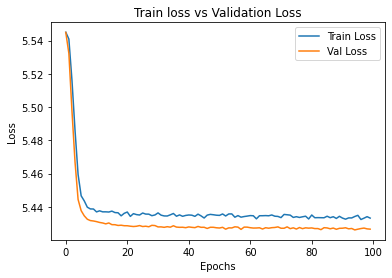

In [ ]:
plot_loss(train_loss, val_loss, save_fig=True)

## Testing

In [ ]:
# Load best model
load_checkpoint(torch.load('my_checkpoint.pth.tar'), model, optimizer)

=> Loading checkpoint


In [ ]:
def test():
  true_frames = []  # batch_wise
  pred_frames = []   # batch_wise
  with torch.no_grad():
    running_loss = 0.0
    for batch_idx, data in enumerate(test_loader):
      input_frames, target_frames = data
      input_frames = input_frames.to(DEVICE)
      target_frames = target_frames.to(DEVICE)

      predicted_frames = model(input_frames)  # upto max predictions (default 1 frame prediction)

      true_frames.append(target_frames)
      pred_frames.append(predicted_frames)

    test_loss = running_loss / len(test_loader)

    true_frames = torch.cat(true_frames, dim=0)
    predicted_frames = torch.cat(pred_frames, dim=0)

  return true_frames, predicted_frames

In [ ]:
true_frames, predicted_frames = test()

predicted_frames = predicted_frames.argmax(dim=1)

true_frames = true_frames.squeeze(1)

true_frames = true_frames.cpu().numpy()
predicted_frames = predicted_frames.cpu().numpy()

### Compute SSIM similarity scores

In [ ]:
def compute_ssim(true_frames, predicted_frames, score_k=1):
  ssim_score = []
  for b in range(true_frames.shape[0]):
    kth_true_frame = true_frames[b][score_k-1]
    kth_predicted_frame = predicted_frames[b][score_k-1]

    score, _ = ssim(kth_true_frame, kth_predicted_frame, full=True)
    ssim_score.append(score)
  
  avg_ssim_score = np.mean(ssim_score)    # average ssim score across test data
  min_ssim_score = np.min(ssim_score)     # minimum ssim score across test data
  max_ssim_score = np.max(ssim_score)     # maximum ssim score across test data

  return avg_ssim_score, min_ssim_score, max_ssim_score

In [ ]:
avg_ssim_score, min_ssim_score, max_ssim_score = compute_ssim(true_frames, predicted_frames)
print(f'Average ssim score: {avg_ssim_score}')
print(f'Minimum ssim score: {min_ssim_score}')
print(f'Maximum ssim score: {max_ssim_score}')

Average ssim score: 0.9149042784353417
Minimum ssim score: 0.7386081128215858
Maximum ssim score: 0.9856645220361311


### Visualize Predicted frames

In [ ]:
def visualize_predicted_frames(true_frames, predicted_frames, visualize=20, k=1, title='none',figname='none'):
  frame_indices = np.arange(true_frames.shape[0])
  random.shuffle(frame_indices)
  frame_indices = frame_indices[:visualize]

  num_rows = 2
  num_cols = visualize

  f, ax = plt.subplots(num_rows, num_cols)
  comp = 0

  for i in range(visualize):
    idx = frame_indices[i]
    true_frame = true_frames[idx][k-1]
    predicted_frame = predicted_frames[idx][k-1]
    
    ax[0,i].imshow(true_frame, cmap='gray')
    ax[0,i].set_title('True Frame')
    ax[0,i].axis('off')

    ax[1,i].imshow(predicted_frame, cmap='gray')
    ax[1,i].set_title('Predicted Frame')
    ax[1,i].axis('off')

    f.set_figheight(6)
    f.set_figwidth(15)
  
  f.suptitle(title, fontsize=16)
  plt.savefig(f'{figname}.png')
  plt.show()

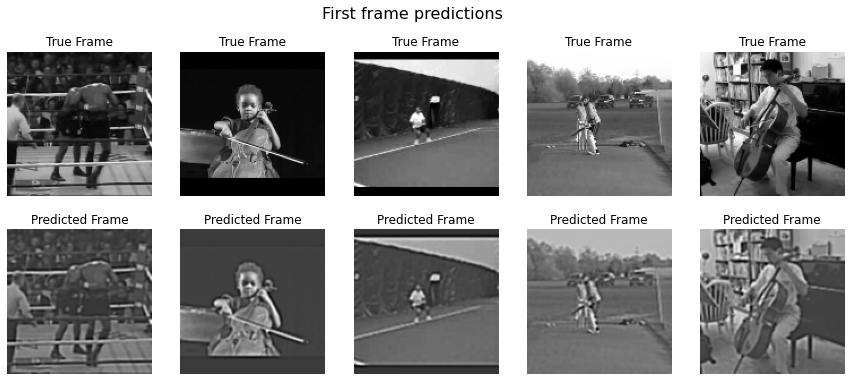

In [ ]:
title = 'First frame predictions'
figname = 'first_frame'
visualize_predicted_frames(true_frames, predicted_frames, visualize=5, k=1, title=title, figname=figname)